Files already downloaded and verified
Epoch [1/20], Loss: 1.5421, Accuracy: 54.84%
Epoch [2/20], Loss: 1.2087, Accuracy: 61.40%
Epoch [3/20], Loss: 1.0783, Accuracy: 65.61%
Epoch [4/20], Loss: 0.9945, Accuracy: 67.03%
Epoch [5/20], Loss: 0.9442, Accuracy: 69.22%
Epoch [6/20], Loss: 0.8927, Accuracy: 70.58%
Epoch [7/20], Loss: 0.8541, Accuracy: 71.38%
Epoch [8/20], Loss: 0.7669, Accuracy: 73.15%
Epoch [9/20], Loss: 0.7505, Accuracy: 73.60%
Epoch [10/20], Loss: 0.7399, Accuracy: 73.89%
Epoch [11/20], Loss: 0.7291, Accuracy: 74.23%
Epoch [12/20], Loss: 0.7233, Accuracy: 73.99%
Epoch [13/20], Loss: 0.7167, Accuracy: 74.72%
Epoch [14/20], Loss: 0.7098, Accuracy: 74.27%
Epoch [15/20], Loss: 0.7034, Accuracy: 74.67%
Epoch [16/20], Loss: 0.6972, Accuracy: 74.32%
Epoch [17/20], Loss: 0.6998, Accuracy: 74.88%
Epoch [18/20], Loss: 0.6963, Accuracy: 75.18%
Epoch [19/20], Loss: 0.6952, Accuracy: 74.86%
Epoch [20/20], Loss: 0.6943, Accuracy: 75.53%


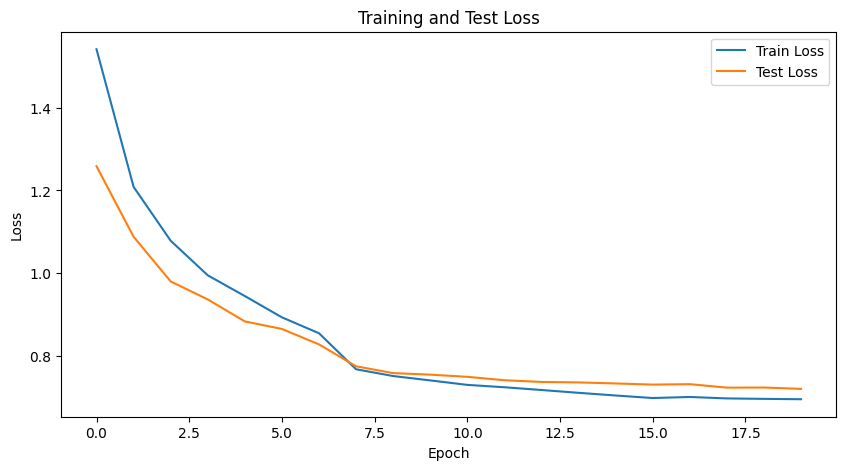

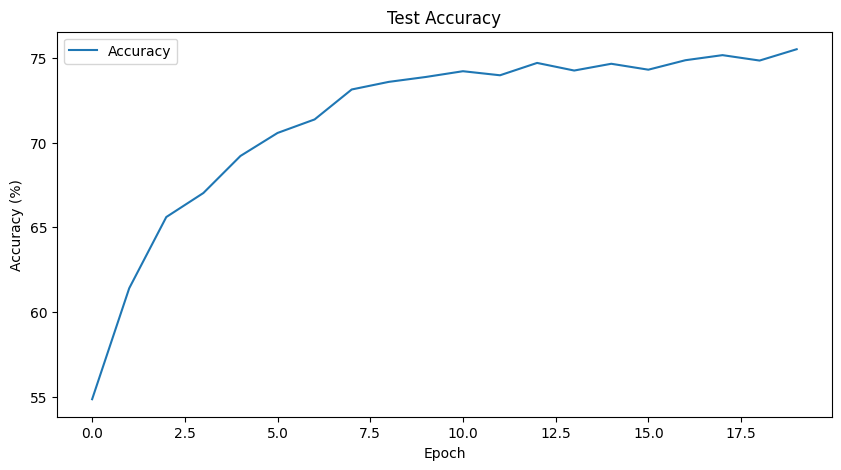

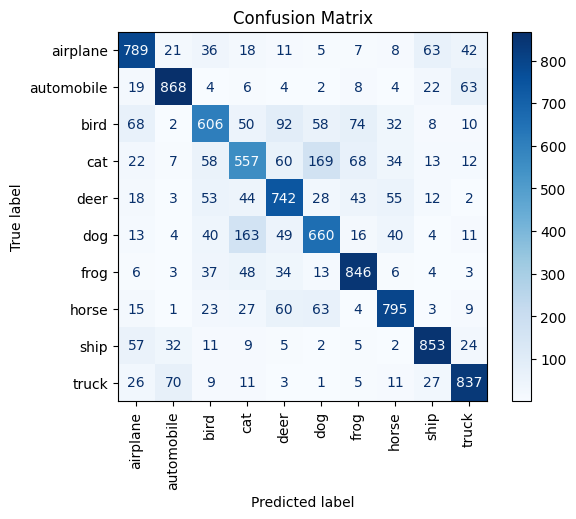

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model, loss, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
train_losses, test_losses, accuracies = [], [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    train_losses.append(running_loss / len(train_loader))

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    accuracy = 100 * correct / total
    accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy')
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=train_dataset.classes).plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Save model
torch.save(model.state_dict(), 'cnn_cifar10.pth')
